## SEC Data V: Quarterly and Annual Values

In [2]:
import pandas as pd
import numpy  as np
import os

In [3]:
def get_items_from_SEC_files(tags, filename=None):               

    directory = 'data/sec/merged/'                                
    filenames = [filename] if filename else os.listdir(directory) 
    filenames = [f for f in filenames if not f.startswith(".")]  

    results   = {t:pd.DataFrame() for t in tags}                  # Dictionary of tables (1 table for each tag)

    for filename in filenames:                                   
        print(filename)
        data = pd.read_csv(directory+filename, parse_dates=['filed','ddate']) 
        
        for t in tags:                                            
            item  = data[data.tag==t]                             
            short = item.sort_values(['cik','filed','ddate','qtrs'], ascending=[True,True,True,False]) # Samllest qrts.
            long  = item.sort_values(['cik','filed','ddate','qtrs'], ascending=[True,True,True,True])  # Largest  qtrs.
            short = short.groupby(['cik','filed']).last()[['value','qtrs']]    
            long  = long .groupby(['cik','filed']).last()[['value','qtrs']]     
            short_long = short.join(long, lsuffix='_shortest', rsuffix='_longest') # Put shortest and longest next to each other.
            results[t] = results[t].append( short_long )  
                        
    for t in tags:                                                # Now sort all tables by filing date.
        if not results[t].empty: results[t] = results[t].sort_index(level='filed')            

    return results

Get all reported R&D expense values for all firms from 2009 until last month:

In [4]:
tags = ['ResearchAndDevelopmentExpense']
items = get_items_from_SEC_files(tags)  

2018q4.csv
2018q3.csv
2018q2.csv
2021_01.csv
2018q1.csv
2020q2.csv
2020q3.csv
2020q1.csv
2019q4.csv
2019q1.csv
2019q3.csv
2019q2.csv
2013q4.csv
2015q2.csv
2015q3.csv
2017q1.csv
2020_12.csv
2020_10.csv
2017q3.csv
2015q1.csv
2017q2.csv
2011q4.csv
2020_11.csv
2013q2.csv
2015q4.csv
2011q1.csv
2013q3.csv
2013q1.csv
2011q3.csv
2017q4.csv
2011q2.csv
2009q4.csv
2014q1.csv
2016q3.csv
2010q4.csv
2016q2.csv
2014q2.csv
2012q4.csv
2016q1.csv
2014q3.csv
2009q2.csv
2010q3.csv
2012q1.csv
2010q2.csv
2016q4.csv
2009q3.csv
2009q1.csv
2014q4.csv
2012q2.csv
2012q3.csv
2010q1.csv


In [8]:
# define item:
item = items['ResearchAndDevelopmentExpense']
item

,,value_shortest,qtrs_shortest,value_longest,qtrs_longest
cik,filed,,,,
883984,2009-04-23,738000.0,1,738000.0,1
884905,2009-04-29,18000000.0,1,18000000.0,1
1164727,2009-04-30,31000000.0,1,31000000.0,1
1080224,2009-05-14,558000.0,1,558000.0,1
38074,2009-05-29,661294000.0,4,661294000.0,4
...,...,...,...,...,...
1350102,2021-01-29,1300000.0,4,1300000.0,4
1385799,2021-01-29,182959.0,4,182959.0,4
1438943,2021-01-29,71975.0,1,338268.0,3


Get the filing dates for all firms:

In [9]:
def get_all_filing_dates(filename=None):                          # Function input: optional filename.

    directory = 'data/sec/merged/'                                # Read data from here.
    filenames = [filename] if filename else os.listdir(directory) # Supplied filename or all files in "merged" directory.
    filenames = [f for f in filenames if not f.startswith(".")]   # Exclude hidden files from file list.
    
    results   = pd.DataFrame()                                    # Results will be appended to this table.

    for filename in filenames:                                    # Loop over all files.
        data    = pd.read_csv(directory+filename, parse_dates=['filed','ddate'])  # Read the file.        
        results = results.append( data.groupby(['cik','filed'],as_index=False).first()[['cik','filed']] )
    
    return results.sort_values(['cik','filed']).set_index('cik')

In [10]:
all_filing_dates = get_all_filing_dates()
all_filing_dates

,filed
cik,
1750,2010-09-23
1750,2010-12-21
1750,2011-03-22
1750,2011-07-13
1750,2011-09-23
...,...
1824920,2020-12-18
1824963,2020-12-10
1825024,2020-12-04


Save the the filing dates table:

In [11]:
all_filing_dates.to_csv('data/sec/dates/filing_dates.csv')

We will need these filing dates now to calculate quarterly/annual R&D expenses.

In [12]:
symbols = pd.read_json('https://www.sec.gov/files/company_tickers.json').transpose().set_index('cik_str')
symbols[:2]

,ticker,title
cik_str,,
320193,AAPL,Apple Inc.
789019,MSFT,MICROSOFT CORP


Apple R&D:

In [15]:
cik = symbols[symbols.ticker=='AAPL'].index[0]

item.loc[cik][:8]

,value_shortest,qtrs_shortest,value_longest,qtrs_longest
filed,,,,
2009-07-22,3.410000e+08,1,9.750000e+08,3
2009-10-27,1.333000e+09,4,1.333000e+09,4
2010-01-25,3.980000e+08,1,3.980000e+08,1
2010-04-21,4.260000e+08,1,8.240000e+08,2
2010-07-21,4.640000e+08,1,1.288000e+09,3
2010-10-27,1.782000e+09,4,1.782000e+09,4
2011-01-19,5.750000e+08,1,5.750000e+08,1
2011-04-21,5.810000e+08,1,1.156000e+09,2


Example:

In [31]:
date   = '2010-10-27'
values = item.loc[cik].value_shortest

# We need to subtract these values:

#previous_values = values[:date][-2:-1] #q = 2
#previous_values = values[:date][-3:-1] #q = 3

q = 4
previous_values = values[:date][-q:-1] #q =4
previous_values

filed
2010-01-25    398000000.0
2010-04-21    426000000.0
2010-07-21    464000000.0
Name: value_shortest, dtype: float64

Subtract the sum of these values from value on that date

In [30]:
values[date] - previous_values.sum()

494000000.0

Loop over all quarters that are greater than 1:

In [33]:
qtrs = item.loc[cik].qtrs_shortest

qtrs[qtrs>1]      # All quarters greater than 1

filed
2009-10-27    4
2010-10-27    4
2011-10-26    4
2012-10-31    4
2013-10-30    4
2014-10-27    4
2015-10-28    4
2016-10-26    4
2017-11-03    4
2018-11-05    4
2019-10-31    4
2020-10-30    4
Name: qtrs_shortest, dtype: object

In [34]:
for date,q in qtrs[qtrs>1].iteritems():
    print('date:', date, 'q:', q)

date: 2009-10-27 00:00:00 q: 4
date: 2010-10-27 00:00:00 q: 4
date: 2011-10-26 00:00:00 q: 4
date: 2012-10-31 00:00:00 q: 4
date: 2013-10-30 00:00:00 q: 4
date: 2014-10-27 00:00:00 q: 4
date: 2015-10-28 00:00:00 q: 4
date: 2016-10-26 00:00:00 q: 4
date: 2017-11-03 00:00:00 q: 4
date: 2018-11-05 00:00:00 q: 4
date: 2019-10-31 00:00:00 q: 4
date: 2020-10-30 00:00:00 q: 4


In [36]:
for date,q in qtrs[qtrs>1].iteritems():                    

    previous_values = values[:date][-q:-1]                           
    
    if len(previous_values) == q-1:                        # If all previous values available
        print (len(previous_values))
        print(date, 'subtract previous values')
    else:
        print (len(previous_values))
        print('not enough data')

1
not enough data
3
2010-10-27 00:00:00 subtract previous values
3
2011-10-26 00:00:00 subtract previous values
3
2012-10-31 00:00:00 subtract previous values
3
2013-10-30 00:00:00 subtract previous values
3
2014-10-27 00:00:00 subtract previous values
3
2015-10-28 00:00:00 subtract previous values
3
2016-10-26 00:00:00 subtract previous values
3
2017-11-03 00:00:00 subtract previous values
3
2018-11-05 00:00:00 subtract previous values
3
2019-10-31 00:00:00 subtract previous values
3
2020-10-30 00:00:00 subtract previous values


Check R&D of Ford:

In [66]:
cik = symbols[symbols.ticker=='F'].index[0] 
item.loc[cik]

,value_shortest,qtrs_shortest,value_longest,qtrs_longest
filed,,,,
2011-02-28,5.000000e+09,4,5.000000e+09,4
2012-02-21,5.300000e+09,4,5.300000e+09,4
2013-02-19,5.500000e+09,4,5.500000e+09,4
2014-02-18,6.400000e+09,4,6.400000e+09,4
2015-02-13,6.900000e+09,4,6.900000e+09,4
2016-02-11,6.700000e+09,4,6.700000e+09,4
2017-02-09,7.300000e+09,4,7.300000e+09,4
2018-02-08,8.000000e+09,4,8.000000e+09,4
2019-02-21,8.200000e+09,4,8.200000e+09,4


All filing dates of Ford:

In [47]:
all_filing_dates.loc[cik][:4]

,filed
cik,
37996,2009-08-05
37996,2009-11-06
37996,2010-02-25
37996,2010-05-07


Add these filing dates to Fords R&D table:

In [49]:
item.loc[cik].reindex(all_filing_dates.loc[cik].filed)

,value_shortest,qtrs_shortest,value_longest,qtrs_longest
filed,,,,
2009-08-05,NaN,NaN,NaN,NaN
2009-11-06,NaN,NaN,NaN,NaN
2010-02-25,NaN,NaN,NaN,NaN
2010-05-07,NaN,NaN,NaN,NaN
2010-08-06,NaN,NaN,NaN,NaN
2010-11-08,NaN,NaN,NaN,NaN
2011-02-28,5.000000e+09,4,5.000000e+09,4
2011-05-10,NaN,NaN,NaN,NaN
2011-08-05,NaN,NaN,NaN,NaN


Now put all this into a fucntion:

In [50]:
def calculate_quarterly_values(item):                              # item: dataFrame
    result           = pd.DataFrame()                              # Results go here.
    all_firms        = item.index.get_level_values('cik').unique() # All unique CIKs
    all_filing_dates = pd.read_csv('data/sec/dates/filing_dates.csv', index_col='cik', parse_dates=['filed'])
    
    for cik in all_firms:                                          # Loop over all firms.  
        filing_dates = pd.Series(all_filing_dates.loc[cik].filed)  # All filing dates for this firm.
        values = item.loc[cik].value_shortest.reindex(filing_dates)
        qtrs   = item.loc[cik].qtrs_shortest.astype(int)
        for date,q in qtrs[qtrs>1].iteritems():                    # Loop over all dates with > 1 quarters. 
            previous_values = values[:date][-q:-1]                 # Example: for q=3 we need to subtract 2 previous quarters.            
            if len(previous_values) == q-1:                        # If all previous values available
                values[date] -= previous_values.sum(skipna=False)  # Subtract previous values.
            else:
                values[date]  = np.nan                  
        result = result.append( pd.DataFrame({'cik':cik, 'filed':values.index, 'value':values.values}) )

    return result.set_index(['cik','filed']).value   


def calculate_annual_values(item, values_1Q):                      # item: dataFrame; values_Q: series
    result           = pd.DataFrame()                              # Results go here.
    all_firms        = item.index.get_level_values('cik').unique() # All CIKs  
    all_filing_dates = pd.read_csv('data/sec/dates/filing_dates.csv', index_col='cik', parse_dates=['filed'])    
    
    for cik in all_firms:                                          # Loop over all firms.
        filing_dates = pd.Series(all_filing_dates.loc[cik].filed)  # All filing dates for this firm.
        valuesQ      = values_1Q.loc[cik].reindex(filing_dates)    # Use 1-quarter values (previously calculated).
        values       = item     .loc[cik].value_longest.reindex(filing_dates)
        qtrs         = item     .loc[cik].qtrs_longest.astype(int)
        for date,q in qtrs[qtrs<4].iteritems():                    # Loop over all dates with < 4 quarters. 
            previous_values = valuesQ[:date][-4:-q]                # Example: for q=2 we need to add quarters -3 and -4.
            if len(previous_values) == 4-q:                        # If all previous data available.     
                values[date] += previous_values.sum(skipna=False)  # Add previous values.
            else:
                values[date]  = np.nan
        result = result.append( pd.DataFrame({'cik':cik, 'filed':values.index, 'value':values.values}) )
                
    return result.set_index(['cik','filed']).value   

In [51]:
item = items['ResearchAndDevelopmentExpense']

In [52]:
itemQ = calculate_quarterly_values(item)
itemQ

cik      filed     
883984   2009-04-23    738000.0
         2009-07-24    617000.0
         2009-10-22    661000.0
         2010-02-19    629000.0
         2010-04-23    918000.0
                         ...   
1436229  2020-03-23         NaN
         2020-05-11         NaN
         2020-08-05         NaN
         2020-11-04         NaN
         2021-01-26         NaN
Name: value, Length: 93660, dtype: float64

In [53]:
itemA = calculate_annual_values(item, itemQ)
itemA

cik      filed     
883984   2009-04-23          NaN
         2009-07-24          NaN
         2009-10-22          NaN
         2010-02-19    2645000.0
         2010-04-23    2825000.0
                         ...    
1436229  2020-03-23          NaN
         2020-05-11          NaN
         2020-08-05          NaN
         2020-11-04          NaN
         2021-01-26      45450.0
Name: value, Length: 93660, dtype: float64

In [55]:
itemQ.to_csv('data/sec/items/RnD_Q.csv')
itemA.to_csv('data/sec/items/RnD_A.csv')

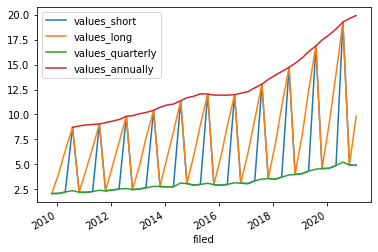

In [58]:
cik = symbols[symbols.ticker=='MSFT'].index[0] 

t = pd.DataFrame()
t['values_short']     = item .loc[cik].value_shortest
t['values_long']      = item .loc[cik].value_longest
t['values_quarterly'] = itemQ.loc[cik]
t['values_annually']  = itemA.loc[cik]

t.div(10**9).plot()